# Intel Image Classification Project
- **Nama:** Muhammad Aldy Naufal Fadhilah
- **Email:** aldy.naufal02@gmail.com
- **ID Dicoding:** aldy_naufal

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Class: buildings | Image: 0.jpg | Original size: (150, 150)
Class: forest | Image: 10007.jpg | Original size: (150, 150)
Class: glacier | Image: 10.jpg | Original size: (150, 150)
Class: mountain | Image: 10000.jpg | Original size: (150, 150)
Class: sea | Image: 1.jpg | Original size: (150, 150)
Class: street | Image: 1000.jpg | Original size: (150, 150)


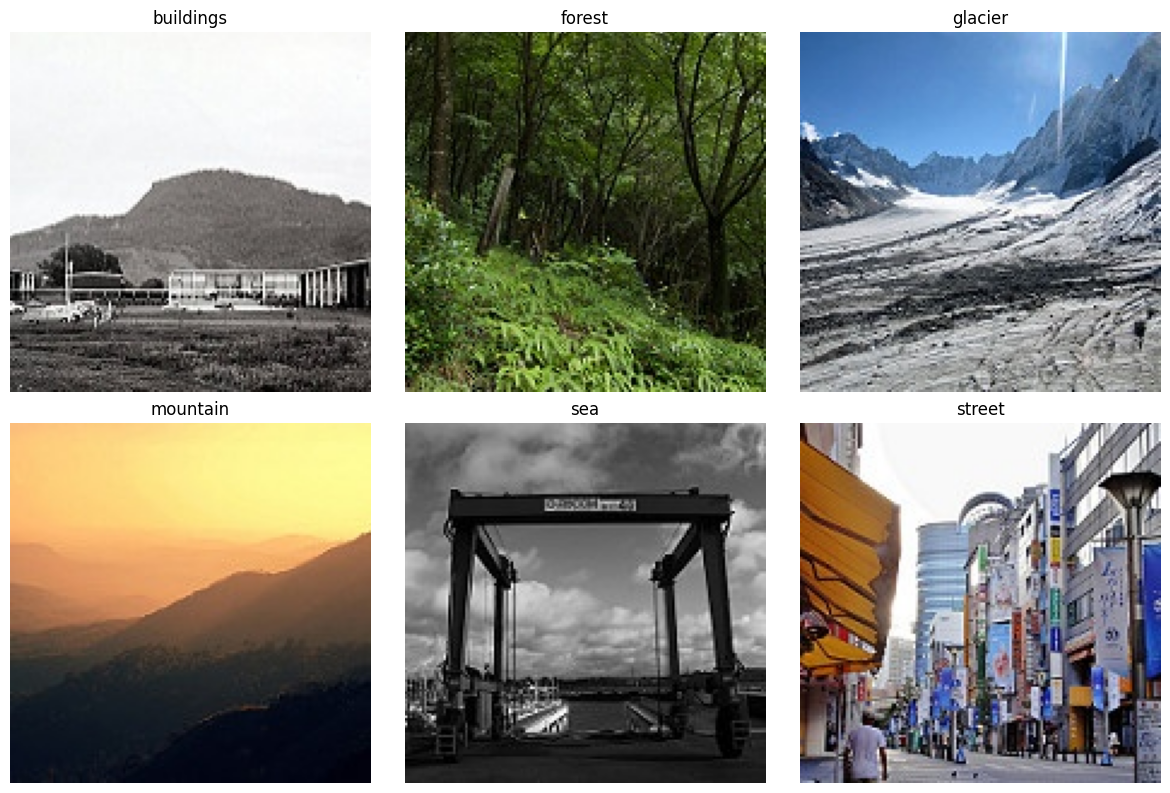

In [12]:
# Path ke folder data train
path = "data/seg_train"

# Ambil semua nama folder class
class_names = os.listdir(path)
print(f"Classes: {class_names}")

# Buat canvas untuk plot
plt.figure(figsize=(12, 8))

# Untuk setiap class, ambil 1 gambar saja
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(path, class_name)

    # List semua gambar dalam folder class
    images = os.listdir(class_path)
    if not images:
        continue  # skip kalau folder kosong

    img_path = os.path.join(class_path, images[0])  # ambil 1 gambar pertama
    img = Image.open(img_path)

    print(f"Class: {class_name} | Image: {images[0]} | Original size: {img.size}")

    # Resize hanya untuk tampilan (contoh: maksimum sisi 256px)
    max_size = 256
    img.thumbnail((max_size, max_size))

    # Plot gambar
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/seg_train",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/seg_val",
    seed=123,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    label_mode='categorical'
)

class_names = train_ds.class_names
print("Kelas:", class_names)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Kelas: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [14]:
# 1. Definisikan data augmentation terpisah
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # Kurangi intensitas
    layers.RandomZoom(0.1),      # Kurangi intensitas
])

In [15]:
# 2. Buat model tanpa augmentasi
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# 3. Terapkan augmentasi pada dataset training
train_ds_augmented = train_ds.map(
    lambda x, y: (data_augmentation(x), y)
)

Images shape: (32, 256, 256, 3)
Labels shape: (32, 6)
Sample labels: [0. 0. 0. 0. 1. 0.]


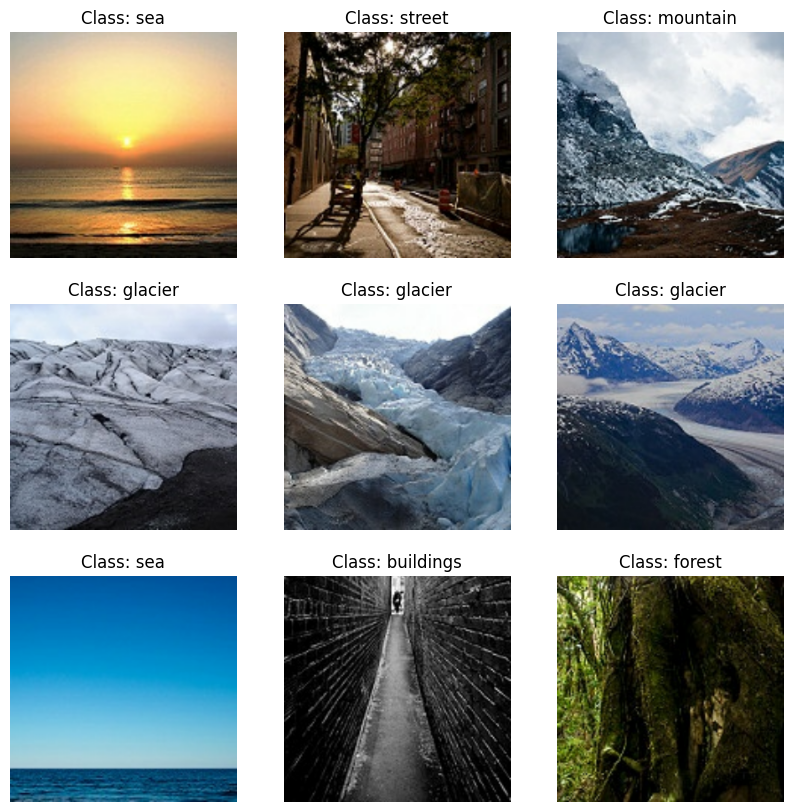

In [ ]:
# Periksa format data
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample labels:", labels[0].numpy())

    # Visualisasikan beberapa gambar
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_idx = tf.argmax(labels[i]).numpy()
        plt.title(f"Class: {class_names[class_idx]}")
        plt.axis("off")
    plt.show()

In [ ]:
# Kompilasi model dengan learning rate yang lebih kecil
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Images shape: (32, 256, 256, 3)
Labels shape: (32, 6)
Sample labels: [0. 0. 0. 1. 0. 0.]


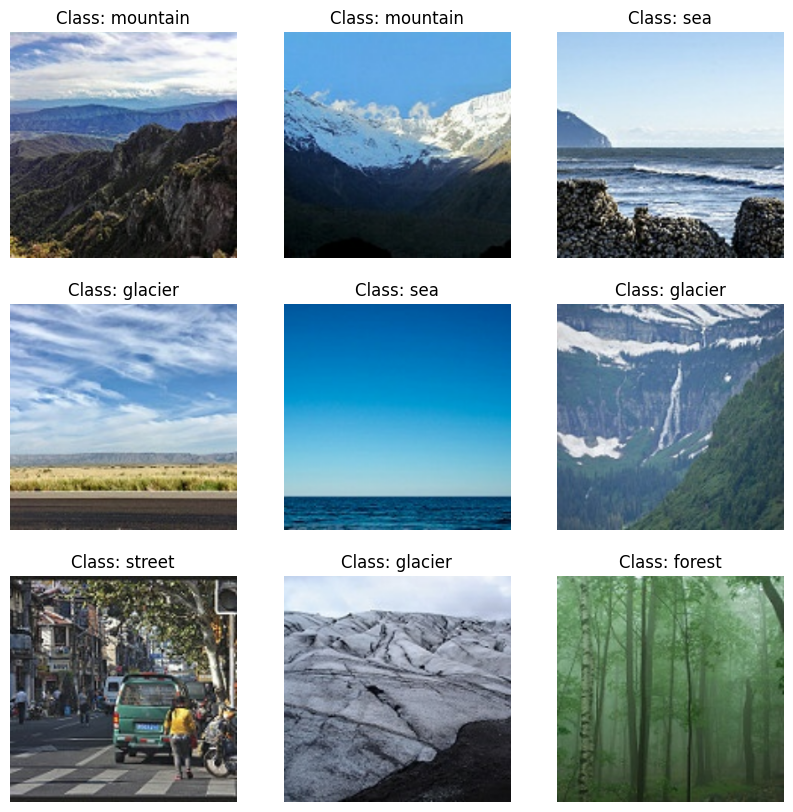

In [ ]:
# Periksa format data
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample labels:", labels[0].numpy())

    # Visualisasikan beberapa gambar
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_idx = tf.argmax(labels[i]).numpy()
        plt.title(f"Class: {class_names[class_idx]}")
        plt.axis("off")
    plt.show()

In [ ]:
class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.95):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.threshold:
            print(f"\n✅ Val accuracy {val_acc:.2f} reached threshold {self.threshold}, stopping training.")
            self.model.stop_training = True


In [ ]:
# Early stopping dengan patience yang lebih besar
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Lebih sabar
    restore_best_weights=True
)

# Learning rate scheduler yang lebih lambat dalam menurunkan learning rate
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,  # Kurangi learning rate dengan faktor yang lebih kecil
    patience=3,  # Tunggu lebih lama sebelum menurunkan learning rate
    min_lr=1e-6
)

# Checkpoint untuk menyimpan model terbaik
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_accuracy'
)

In [ ]:
# Lakukan training dengan dataset yang sudah diaugmentasi
history = model.fit(
    train_ds_augmented,  # Gunakan dataset yang sudah diaugmentasi
    validation_data=val_ds,  # Dataset validasi tanpa augmentasi
    epochs=30,  # Tambah jumlah epoch
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

Epoch 1/30


439/439 [==============================] - 696s 2s/step - loss: 1.0506 - accuracy: 0.6132 - val_loss: 1.3921 - val_accuracy: 0.5437 - lr: 1.0000e-04
Epoch 2/30
439/439 [==============================] - 668s 2s/step - loss: 0.8159 - accuracy: 0.7022 - val_loss: 0.7772 - val_accuracy: 0.7243 - lr: 1.0000e-04
Epoch 3/30
439/439 [==============================] - 591s 1s/step - loss: 0.7520 - accuracy: 0.7235 - val_loss: 0.8237 - val_accuracy: 0.7217 - lr: 1.0000e-04
Epoch 4/30
439/439 [==============================] - 597s 1s/step - loss: 0.6970 - accuracy: 0.7470 - val_loss: 0.6588 - val_accuracy: 0.7653 - lr: 1.0000e-04
Epoch 5/30
439/439 [==============================] - 591s 1s/step - loss: 0.6738 - accuracy: 0.7545 - val_loss: 0.5432 - val_accuracy: 0.8027 - lr: 1.0000e-04
Epoch 6/30
439/439 [==============================] - 595s 1s/step - loss: 0.6350 - accuracy: 0.7706 - val_loss: 0.5794 - val_accuracy: 0.8047 - lr: 1.0000e-04
Epoch 7/30
439/439 [==================

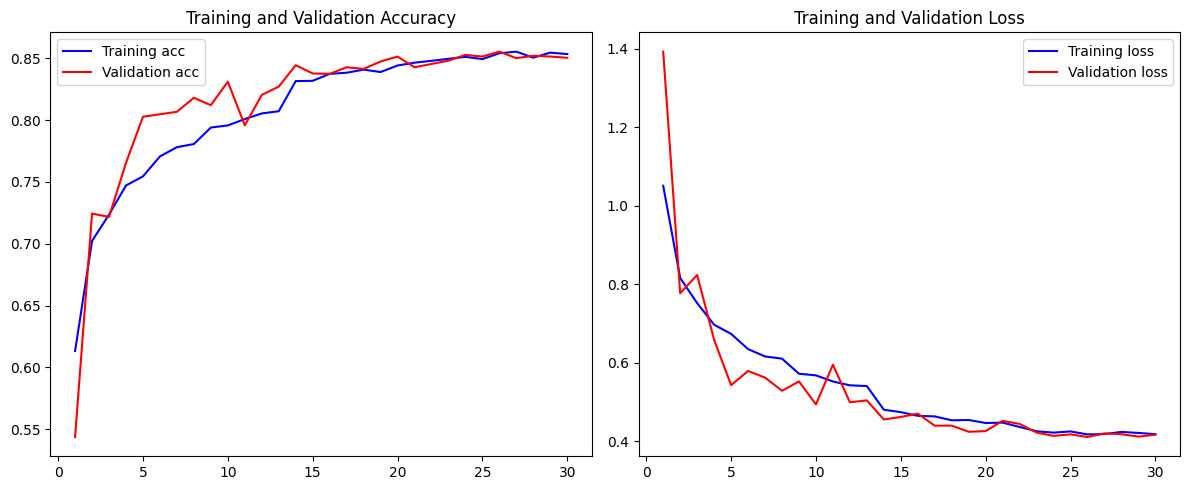

In [ ]:
# Plot accuracy dan loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Menggunakan model pre-trained
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

inputs = tf.keras.Input(shape=(256, 256, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

base_model.trainable = True

# Pilih layer mulai fine-tuning (misal hanya 30 layer terakhir)
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # learning rate lebih kecil
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # lanjutkan training
)


Epoch 1/10


439/439 [==============================] - 391s 877ms/step - loss: 0.4572 - accuracy: 0.8341 - val_loss: 0.2549 - val_accuracy: 0.9053
Epoch 2/10
131/439 [=======>......................] - ETA: 4:49 - loss: 0.2580 - accuracy: 0.9062

In [7]:
model.export("saved_model")  # folder akan dibuat otomatis


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135890418030864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418035088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418038160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418037776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418037200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418034320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418037008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418037968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418038736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418035280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135890418039120

In [8]:
# Convert to TFLite
os.makedirs("tflite", exist_ok=True)
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

# Simpan ke file
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# 5. Simpan label.txt (dari class_names)
with open("tflite/label.txt", "w") as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")


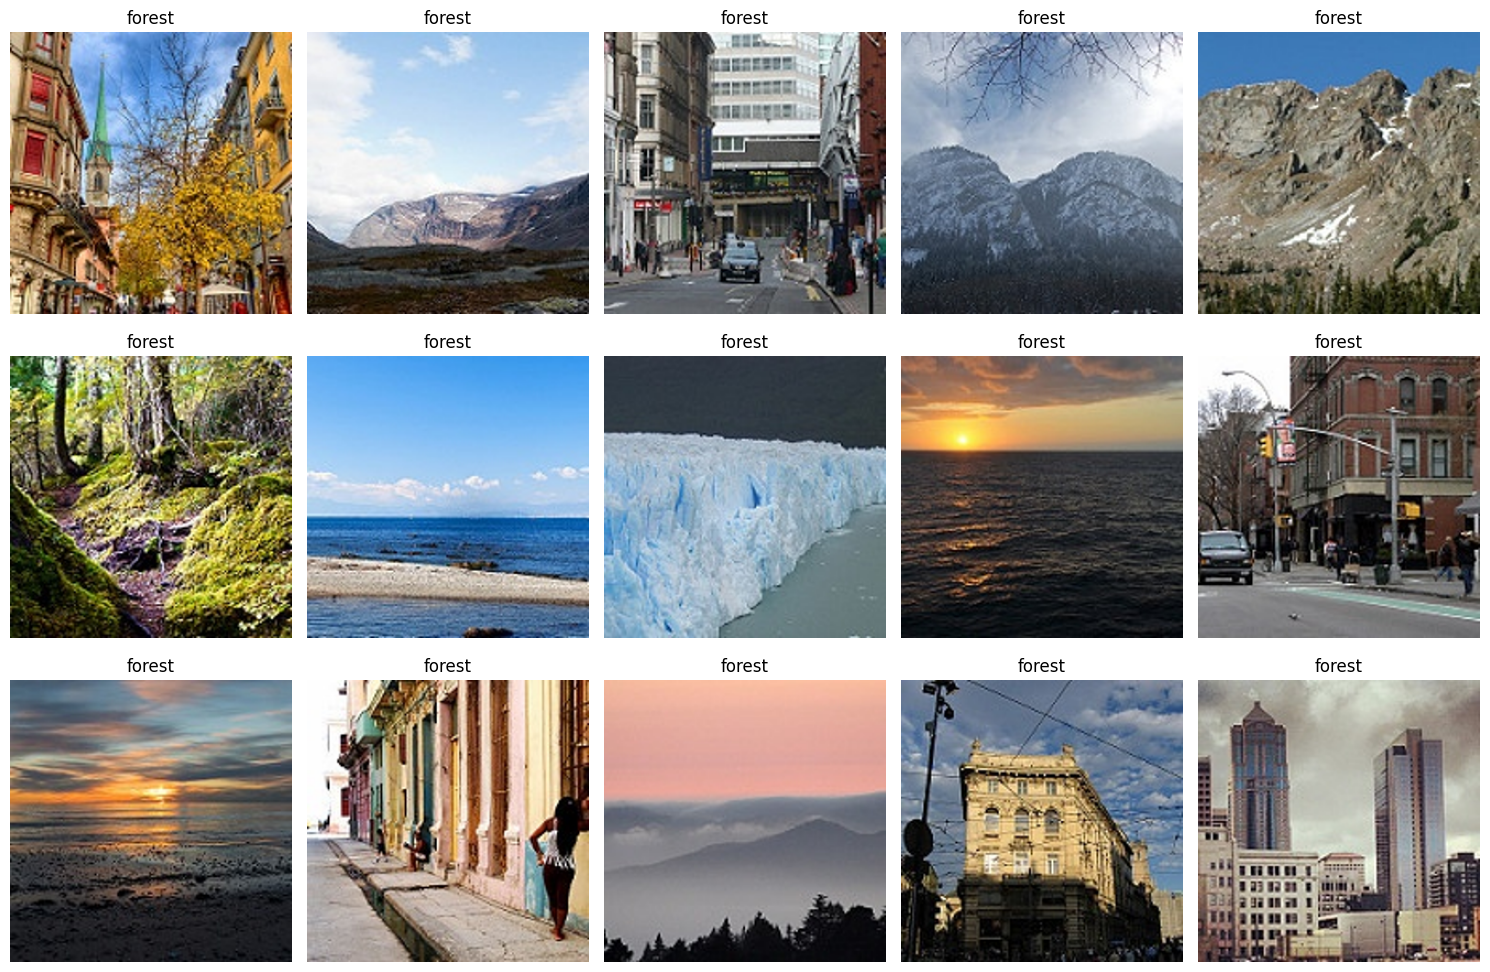

In [7]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

# Path
tflite_model_path = "tflite/model.tflite"
label_path = "tflite/label.txt"
test_dir = "data/seg_test"
img_size = (256, 256)

# Load label
with open(label_path) as f:
    class_names = [line.strip() for line in f]

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocess image
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB").resize(img_size)
    img_array = np.array(img).astype(np.float32)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0), img

# Ambil dan sort nama file
img_paths = sorted([
    os.path.join(test_dir, fname)
    for fname in os.listdir(test_dir)
    if fname.lower().endswith(".jpg")
])[:15]  # hanya 15 gambar

# Plotting
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(img_paths):
    img_tensor, img_raw = load_and_preprocess_image(img_path)
    
    interpreter.set_tensor(input_details[0]['index'], img_tensor)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    
    predicted_idx = np.argmax(output)
    predicted_label = class_names[predicted_idx]
    
    # Tampilkan gambar + prediksi
    plt.subplot(3, 5, i + 1)
    plt.imshow(img_raw)
    plt.title(predicted_label)
    plt.axis('off')

plt.tight_layout()
plt.show()
